In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


              SRNO        HEATNO  COKE_REQ  INJ1_QTY\n(Coke Injection Qty)  \
count  2059.000000   2059.000000    2059.0                     2059.000000   
mean    345.174356  44970.710539       0.0                        0.014845   
std     199.945717    607.391378       0.0                        0.137097   
min       1.000000  43916.000000       0.0                       -4.161996   
25%     173.000000  44445.500000       0.0                        0.000000   
50%     344.000000  44974.000000       0.0                        0.005375   
75%     516.000000  45496.500000       0.0                        0.037432   
max     731.000000  46021.000000       0.0                        1.928703   

       INJ2_QTY\n(Coke Injection Qty)          BSM      TP    MSTB  \
count                     2059.000000  2059.000000  2059.0  2059.0   
mean                         0.099721     3.465274     0.0     0.0   
std                          0.072460     3.136068     0.0     0.0   
min              

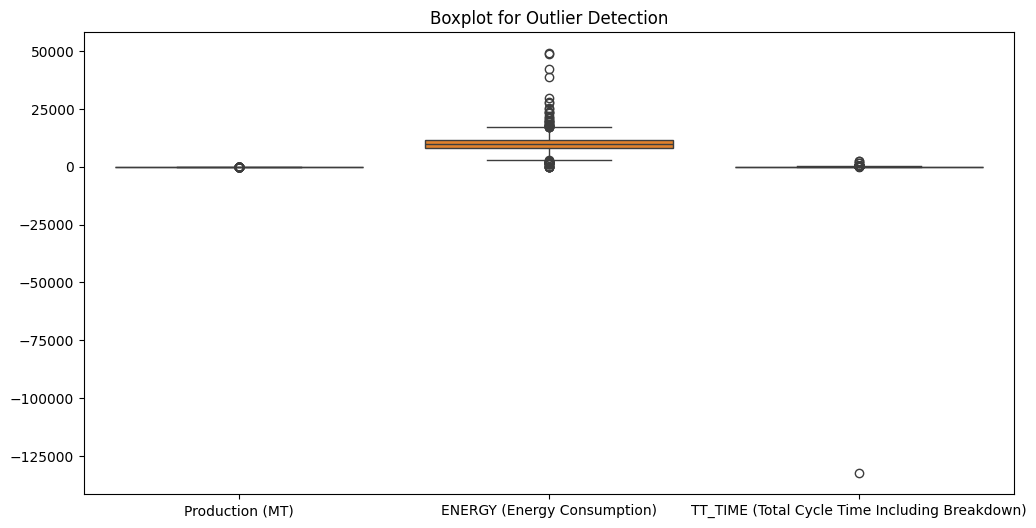

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
filterwarnings('ignore')
# Load Dataset
file_path = "/content/Latest_Manufacturing(FOR_EDA).csv"
df = pd.read_csv(file_path)

# Exploratory Data Analysis (EDA)
print(df.describe())  # Summary statistics
print(df.isnull().sum())  # Check for missing values

# Visualizing distributions
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['Production (MT)', 'ENERGY (Energy Consumption)', 'TT_TIME (Total Cycle Time Including Breakdown)']])
plt.title("Boxplot for Outlier Detection")
plt.show()




In [5]:
# Removing outliers using IQR method for numeric columns only
numeric_df = df.select_dtypes(include=np.number)
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[~((numeric_df < lower_bound) | (numeric_df > upper_bound)).any(axis=1)]


In [10]:
# Drop irrelevant columns (ID-like and datetime columns)
df.drop(columns=['SRNO', 'DATETIME', 'HEATNO'], inplace=True)

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [11]:
# Scaling numerical features
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

OUTPUT COLUMNS ARE -Production (MT),  TT_TIME (Total Cycle Time Including Breakdown), ENERGY (Energy Consumption) PERFORM CLUSTERING IN THESE THREE OUTPUT COLUMNS.THEN ONE DISCRETE COLUMN WILL BE CREATED

In [12]:
# Clustering on key features
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Production (MT)', 'ENERGY (Energy Consumption)', 'TT_TIME (Total Cycle Time Including Breakdown)']])



In [13]:
# Prepare data for classification
X = df.drop(columns=['Cluster'])
y = df['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from google.colab import files
csv_filename = 'clustering.csv'
df.to_csv(csv_filename, index=False)
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier()
}

In [15]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = accuracy_score(y_test, y_pred)

# Display results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
print(results_df)

                        Accuracy
Logistic Regression     0.983010
K-Nearest Neighbors     0.791262
Support Vector Machine  0.953883
Random Forest           0.946602


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define hyperparameter grid
param_grid = {
    'n_neighbors': range(1, 21, 2),  # Testing odd values of k
    'weights': ['uniform', 'distance'],  # Weighting schemes
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Perform Grid Search to find best parameters
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Train the best model
best_knn = grid_search.best_estimator_
best_knn.fit(X_train, y_train)

# Predict using the best KNN model
y_pred_knn = best_knn.predict(X_test)

# Evaluate the new accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Improved KNN Accuracy: {knn_accuracy:.4f}")

# Display best parameters
print("Best parameters for KNN:", grid_search.best_params_)


Improved KNN Accuracy: 0.8447
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


**What This Does:**
Uses GridSearchCV to find the best k, weights, and metric.

Selects the best model based on cross-validation.

Trains and evaluates the optimized KNN classifier.